# Project: Connect nodes in 3D using min cost method 


### Connection  algorth 
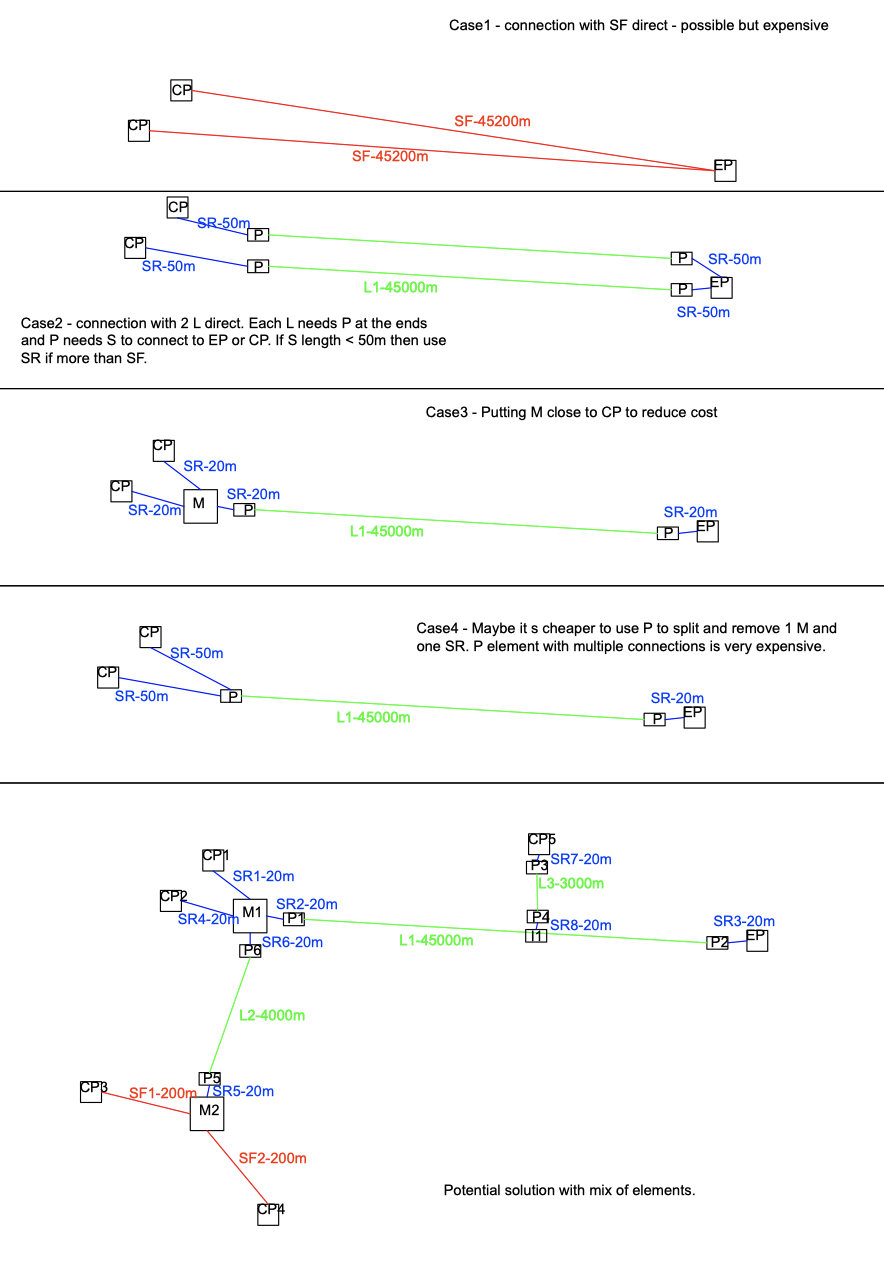
Given are CP and EP locations (X,Y). And the algorith should connect all CP with EP using minimal cost. Maybe using: https://en.wikipedia.org/wiki/Simplex_algorithm

# input data

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
# import utm
import math
import random
from tqdm import tqdm as pb 
import shapely.geometry as geometry
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
import sklearn.neighbors
terrain_f_n = "/Users/smavrovic/Documents/GitHub/Python_Traning/Pydot25/resources/ProjectData/GEBCO_2019_-5.0_63.0_-1.0_60.0.nc"
xutm= 595815.05
yutm= 6705300.32

# Find min cost path

## Input data

In [3]:
radius = 200
rangeX = (-50000, 2500)
rangeY = (-2000, 250000)
qty = 45  # or however many points you want
z=0

# Generate a set of all points within 200 of the origin, to be used as offsets later
# There's probably a more efficient way to do this.
deltas = set()
for x in range(-radius, radius+1):
    for y in range(-radius, radius+1):
        if x*x + y*y <= radius*radius:
            deltas.add((x,y))

randPoints = []
excluded = set()
i = 0
while i<qty:
    x = random.randrange(*rangeX)
    y = random.randrange(*rangeY)
    if (x,y) in excluded: continue
    randPoints.append((x,y,z))
    i += 1
    excluded.update((x+dx, y+dy) for (dx,dy) in deltas)
wells = randPoints
wells

[(-16658, 91209, 0),
 (1988, 83533, 0),
 (-48219, 152161, 0),
 (-33152, 33231, 0),
 (-13414, 11400, 0),
 (-35741, 245411, 0),
 (-107, 124760, 0),
 (-47212, 103396, 0),
 (-33644, 113894, 0),
 (-32462, 36917, 0),
 (-40125, 201102, 0),
 (-31402, 221065, 0),
 (-4740, 95621, 0),
 (-30933, 29516, 0),
 (-4899, 153149, 0),
 (-49162, 106245, 0),
 (1388, 209948, 0),
 (-14514, 67619, 0),
 (-46137, 59312, 0),
 (-43919, 7342, 0),
 (1623, -178, 0),
 (-14304, 96775, 0),
 (-13584, 177312, 0),
 (-41208, 232602, 0),
 (-28977, 73564, 0),
 (-38494, 138819, 0),
 (-33166, 85603, 0),
 (-30884, 118034, 0),
 (-17982, 135999, 0),
 (-41923, 181519, 0),
 (-17953, 144633, 0),
 (-40927, 36328, 0),
 (-10371, 210749, 0),
 (-30023, 146829, 0),
 (-25318, 199086, 0),
 (-24558, 232169, 0),
 (-47945, 14642, 0),
 (-15883, 222719, 0),
 (-6958, 240178, 0),
 (-20419, 195460, 0),
 (-9182, 166630, 0),
 (-27665, 80511, 0),
 (-43302, 68228, 0),
 (-21566, 39835, 0),
 (-2093, 174738, 0)]

## define cost dataframe, for now simple only lines and manifold

In [4]:
'''
cost has variable x. For manifold this is number of connections and for line this is length.
We will simply refere this as qty in out dataframe. 
'''
c_df = pd.DataFrame({"Element":["l", "m", "sf"], 
                    "unit_cost":[1, 100, 5],
                    "cost_formula":[ "1*x",
                                     "0.4545*x**4 - 5.0505*x**3 + 25*x**2 - 43.781*x + 122.86",
                                     "5*x"
                        
                    ]})
c_df

,Element,unit_cost,cost_formula
0,l,1,1*x
1,m,100,0.4545*x**4 - 5.0505*x**3 + 25*x**2 - 43.781*x...
2,sf,5,5*x


In [5]:
for x in range(10):
    print(eval(c_df["cost_formula"][1]))

122.86
99.483
102.166
116.968
140.856
181.70499999999998
258.29799999999994
400.3259999999998
648.3879999999998
1053.9909999999998


## define functions

In [6]:
def connect(point1, point2):
    '''
    takes 2 points and returns line object
    '''
    firstPoint = point1
    lastPoint = point2
#     findPath HOLD
    path = [firstPoint,lastPoint]
    l=LineString(path)
    return l

In [7]:
def calCost(c_df, items_df):
    '''
    from two dataframes calculates cost
    '''
    cost=[]
    _mdf = pd.DataFrame()
    _mdf = items_df.reset_index().merge(c_df, on=["Element"]).set_index('index') 
    _mdf.sort_index(inplace=True) #problem reindex after merge and not possible to get list back
    for index, item in list(_mdf.iterrows()):
        x=item.qty
        _cost=eval(item.cost_formula)
        cost.append(_cost)
    return cost

In [8]:
def testManifoldLocations(wells, maxNum):
    items_df = pd.DataFrame()
    m_l=[]
    if maxNum%3==0: col = 3
    else: col = 2
    row= round(maxNum/col)
    fig, ax = plt.subplots(nrows=row, ncols=col)
    SIZE = (15,20)
    fig.set_size_inches(SIZE)
    i=0
    for row in ax:
        for col in row:
            i+=1
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            pred_y = kmeans.fit_predict(wells)
            m_ix = kmeans.fit_predict(wells)
            m_loc = kmeans.cluster_centers_
            m_l.append({"noOfManifolds": i, "locations:":m_loc})
            _items_df=connectSystem(wells, m_loc, m_ix)
            items_df = items_df.append(_items_df,ignore_index=True, sort=False)
            col.scatter(wells[:,0], wells[:,1])
            col.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
            col.set_xlabel(f'{i} manifolds', labelpad = 5)
    plt.show()   
    return m_l

In [9]:
def addM2(number,wells):
    '''
    Add manifold to a centre location of a clusted. One manifold per one cluster. 
    
    :param number: is number of m to be put and it will find also number of clusters
    :param nodes_array:  np array of points
    :param method:
        mid - puts the M in the center of the cluster
        
    '''
    if number == 0: return [],[]
    kmeans = KMeans(n_clusters=number, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(wells)
    m_ix = kmeans.fit_predict(wells)
    m_loc = kmeans.cluster_centers_
    m_np=m_loc
#     m_np = np.array(m_loc)
    return m_np, m_ix

In [10]:
def addM(number,nodes_array, method="mid"):
    '''
    Add manifold to a centre location of a clusted. One manifold per one cluster. 
    
    :param number: is number of m to be put and it will find also number of clusters
    :param nodes_array:  np array of points
    :param method:
        mid - puts the M in the center of the cluster
        
    '''
    if number == 0: return [],[]
    clustering = SpectralClustering(n_clusters=number,
         assign_labels="discretize",
         random_state=0).fit(nodes_array)
    _arr = []
    _m=[]
    for cluster in range(number):
        for i, mask in enumerate(clustering.labels_):
            if mask == cluster:          
                _arr.append(nodes_array[i])
        arr=np.array(_arr)    
                
        if method == "mid":
            length, dim = arr.shape
            _m.append([np.sum(arr[:, i])/length for i in range(dim)])
    m_np = np.array(_m)
#     m_np = _m
    return m_np, clustering.labels_

In [11]:
def connectSystem(w_loc, m_loc=[], m_ix=[], ep_loc=[float(0),float(0),float(0)]):
    '''
    Connects all wells to the nearest manifold or end point. Then connectes all manifolds and end point. 
    Returns a dataframe with lines and lengths and manifolds and number of connections to every manifold. 
    
    :param w_loc: list of well locations [[x1,y1,z1],...[xn,yn,zn]]
    :param m_loc: numpy array of position of manifolds
    :paramm_ix: numpy array of index showing cluster number for every well
    :paramep_loc: location of end point
    '''
    l=[]
    _d={"Element": [],
          "qty": [],
          "positions": [],
          "case":[]}
    
    # treat clusters and end point as connecting nodes, in order to find best connections
    eps=[] 
    for i in m_loc:
        eps.append(i.tolist())
    eps.append(ep_loc)
    eps=np.array(eps)
    
    # find nearest cluster to connect wells to
    tree = sklearn.neighbors.KDTree(eps)
    # this connects all wells with the nearest cluster point
    # needs a verification if the nearest is also the one chosen by the cluster HOLD
    for w in w_loc:    
        d, i = tree.query([w])
        new_origin = tree.get_arrays()[0][i[0][0]]
        distance = d[0][0]
        _l = connect(w,new_origin)
        l.append(_l)
#         print(len(_l.xy))

    # now we need to connect all cluster points by excluding the current cp from the possible connections    
    for kk, ep in enumerate(eps):
#         print("eps",eps, eps.shape)
#         print("ep",ep, ep.shape)

        if eps.shape[0] == 1: 
            continue

        eps_m = np.delete(eps,kk,0)
        tree = sklearn.neighbors.KDTree(eps_m)
        d, i = tree.query([ep])
        new_origin = tree.get_arrays()[0][i[0][0]]
        distance = d[0][0]
#         print(f"From node {ep} closest node is {new_origin} with distance {distance}")
#         print(f"Nodes list to choose closest is {eps_m}")
        _l=connect(ep,new_origin)
        l.append(_l)
#         print(len(_l.xy))
    
     # put data in dataframe
    for item in l:
        _d["Element"]= _d["Element"] + ["l"]
        _d["qty"]= _d["qty"]+ [item.length]
        _d["positions"]=_d["positions"]+ [item]
        _d["case"]=_d["case"]+ ["m="+str(len(m_loc))]
    for m in m_loc:
        _d["Element"]= _d["Element"] + ["m"]
        count=0
        for item in l:
            if (m == item.coords[0]).all() or (m==item.coords[-1]).all():
                count+=1
#                 print(f"M {m} connects line from {item.coords[0]} to {item.coords[-1]}")
#         print(f" case {str(len(m_loc))} m {m} has {count} connections")
        _d["qty"]= _d["qty"]+ [count]
        _d["positions"]=_d["positions"]+ [m]
        _d["case"]=_d["case"]+ ["m="+str(len(m_loc))]
    df = pd.DataFrame(_d)

    return df

In [12]:
'''
Plotting code
'''

from matplotlib import pyplot
from shapely.figures import SIZE, set_limits, plot_coords, plot_bounds, plot_line_issimple

COLOR = {
    True:  '#6699cc',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def plot_df(items_df):
    SIZE = (10,10)
    fig = pyplot.figure(1, figsize=SIZE, dpi=90)

    for case_ix, case in enumerate(items_df["case"].unique()):
        case_m=items_df["case"]==case
        l_m=items_df["Element"]=="l"
        mask= case_m & l_m
        ax = fig.add_subplot(321+case_ix)


        for i in range(items_df[mask]["Element"].count()):
            line = items_df[mask]["positions"].values[i]
            print(line)

            plot_coords(ax, line)
            plot_bounds(ax, line)
            plot_line_issimple(ax, line, alpha=0.7)

        ax.set_title(case)

    pyplot.show()

## Main - run loop to place i number of M structures in the centre of the cluster

In [13]:

items_df = pd.DataFrame()
for i in range(16,17,5):
    m_loc, m_ix=addM2(i,np.array(wells))
#     print(clusters)
#     m_ix = clusters.labels_
    _items_df=connectSystem(wells, m_loc, m_ix)
    items_df = items_df.append(_items_df,ignore_index=True, sort=False)
#     print(f"For case with {i} M structures cost is {_items_df["Cost"].sum()}")

In [14]:
for i in (range(16,17,5)):
    print(i)

16


## Calculate cost for each case

In [15]:
items_df["Cost"] = calCost(c_df,items_df)
items_df.dropna(inplace=True)
items_df.groupby(["case"])["Cost"].sum()

case
m=16    722166.536655
Name: Cost, dtype: float64

In [16]:
# display the data format
items_df.head()

,Element,qty,positions,case,Cost
0,l,8249.598202,"LINESTRING Z (-16658 91209 0, -8428.5 91784.5 0)",m=16,8249.598202
1,l,13288.744279,"LINESTRING Z (1988 83533 0, -8428.5 91784.5 0)",m=16,13288.744279
2,l,0.000000,"LINESTRING Z (-48219 152161 0, -48219 152161 0)",m=16,0.000000
3,l,2355.470093,"LINESTRING Z (-33152 33231 0, -31808 35165.399...",m=16,2355.470093
4,l,9488.960072,"LINESTRING Z (-13414 11400 0, -5895.5 5611 0)",m=16,9488.960072


## Plot the cases on the graph
Looks like that clustering does not work as it should. 

LINESTRING Z (-16658 91209 0, -8428.5 91784.5 0)
LINESTRING Z (1988 83533 0, -8428.5 91784.5 0)
LINESTRING Z (-48219 152161 0, -48219 152161 0)


ValueError: not enough values to unpack (expected 2, got 0)

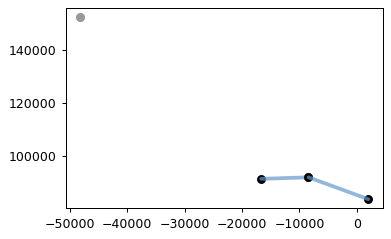

In [17]:
plot_df(items_df)

## Troubleshooting
### Plot to see if clustering works well
NOT working as expected

In [ ]:
clustering = SpectralClustering(n_clusters=5,
     assign_labels="discretize",
     random_state=0).fit(wells)
clustering.labels_

wdf = pd.DataFrame(wells)
wdf.columns=["x","y","z"]
# cp_df.plot("x","y")
import seaborn as sns
wdf["cluster"] = clustering.labels_
sns.scatterplot(x="x", y="y", data=wdf, hue="cluster")

## Plot Wells, Manifolds and EP in different colour
### Conclusion - Manifold locations are very close to each other because they are put in the centre of the cluster. We saw that the clustering does not group the nodes as expected so another clustering algorith is needed. 

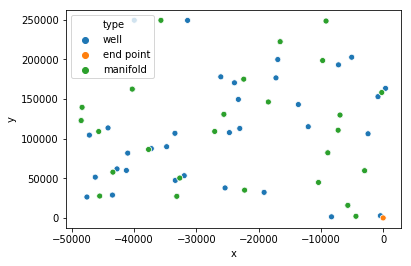

In [41]:
cp_df = pd.DataFrame(wells)
cp_df.columns=["x","y","z"]
# cp_df.plot("x","y")
import seaborn as sns

cp_df["type"] = "well"
cp_df.loc[-1] = [0,0,0,"end point"]
mdf = pd.DataFrame(m_loc)
mdf.columns=["x","y","z"]
mdf["type"] = "manifold"
all_df= pd.concat([cp_df,mdf])

sns.scatterplot(x="x", y="y", data=all_df, hue="type")

 ## Try to do it in the graph structure - HOLD

In [ ]:
def get_xy(G,i):
    return (G.node[i]['node_lat'],G.node[i]['node_lon'])

def get_cost(G):
    unit_cost = 1
    acc = 0
    for edge in G.edges(data=True):
        acc = acc + (edge[-1]['length'] * unit_cost)
    return acc

In [ ]:
import networkx as nx
G = nx.Graph()

def get_default_graph():

    for index, p in list(cp_df.iterrows())[:-1]:
        print(p.x, p.y, p.z)
        G.add_node(index, weight=1, UTM=('30V', p.x, p.y), node_lat=p.x, node_lon=p.y)

    index, p = list(cp_df.iterrows())[-1]
    G.add_node("ep", weight=20, UTM=('30V', p.x, p.y), node_lat=p.x, node_lon=p.y)


    # G.add_edges_from([])
    for i in range(len(G.nodes)-1): 
        G.add_edge(i, "ep", length=connect( get_xy(G,i), get_xy(G, "ep")  ))

    return G

In [ ]:
G = get_default_graph()

In [ ]:
G.node(data=True)

In [ ]:
org_best = get_cost(G)
org_best

In [ ]:
nx.draw(G)

In [ ]:
G1 = get_default_graph()

In [ ]:
nx.draw(G1)

In [ ]:
for i in range(len(G.nodes)-1): 
    print(i)
    G.add_edge(i, "ep", lenght=1)

In [ ]:
# !pip install nxviz

In [ ]:
# import nxviz as nxv

In [ ]:
# nxv.GeoPlot(G)